### Quick implementation of Hodgkin-Huxley model of excitable membrane

**Aim**: demonstrate the generation of action potentials by a Hodgkin-Huxley membrane model with constant driving current.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

Equilibrium Na activation ($m_0$), Na inactivation ($h_0$), and K activation ($n_0$) -- all functions of membrane potential:

In [2]:
# The simple examples below share a common functional form, but since we might want to change that in
# future it makes sense to code them as distinct functions.

def m_0(V):
    V_half = 0.03 #volts
    k = 0.01 #volts
    return 1 / (1 + math.exp((V_half - V)/k))

def h_0(V):
    V_half = 0
    k = -0.01
    return 1 / (1 + math.exp((V_half - V)/k))

def n_0(V):
    V_half = 0.016
    k = 0.019
    return 1 / (1 + math.exp((V_half - V)/k))

Time constants for relaxation of $m$, $h$ and $n$ to their equilibrium values:

In [3]:
# Again, kept as distinct functions for sake of flexibility 

def T_m(V):
    C_base = 0.00001
    C_amp = 0.0005 #seconds
    V_max = 0.025 #volts
    sigma = 0.035 #volts; this is 1/e width, not st dev
    return C_base + C_amp * math.exp(-(V_max - V)**2 / sigma**2)

def T_h(V):
    C_base = 0.001
    C_amp = 0.0075
    V_max = -0.0025
    sigma = 0.026
    return C_base + C_amp * math.exp(-(V_max - V)**2 / sigma**2)

def T_n(V):
    C_base = 0.0002
    C_amp = 0.0056
    V_max = -0.015
    sigma = 0.061
    return C_base + C_amp * math.exp(-(V_max - V)**2 / sigma**2)

Membrane characteristics and reversal potentials:

In [4]:
C = 1e-6 #membrane capacitance in F/cm2

g_K = 0.036 #max K conductance in S/cm2
g_Na = 0.120 #max Na conductance
g_L = 0.0003 #max leak conductance

V_K = -0.012 #K reversal in volts
V_Na = 0.115 #Na reversal
V_L = -(m_0(0)**3 * h_0(0) * g_Na * V_Na + n_0(0)**4 * g_K * V_K) / g_L #set V_L to give resting potential = 0

This function defines the Hodgkin-Huxley dynamics in $<u, m, h, n>$ phase space:

In [5]:
# computes velocity in <u, m, h, n> phase space
def hh_flow(t, state_vector):
    assert len(state_vector) == 4
    u, m, h, n = state_vector # unpack state vector into membrane voltage, Na activation, Na inactivation, and K activation
    u_dot = (1/C)*(I(t) - g_Na*m**3*h*(u - V_Na) - g_K*n**4*(u - V_K) - g_L*(u - V_L)) # driving current I(t) defined below
    m_dot = -(m - m_0(u))/T_m(u)
    h_dot = -(h - h_0(u))/T_h(u)
    n_dot = -(n - n_0(u))/T_n(u)
    return u_dot, m_dot, h_dot, n_dot

Now we can define a driving current, integrate the first-order ODE system defined above, and plot the dynamical variables against time.

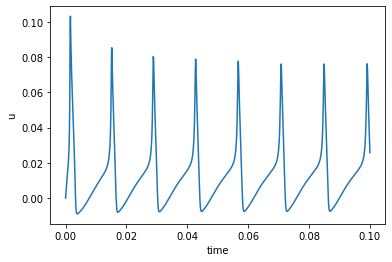

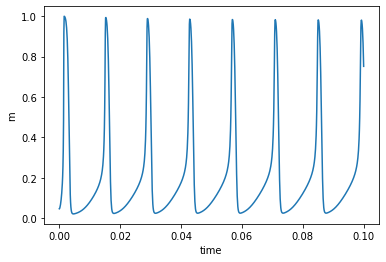

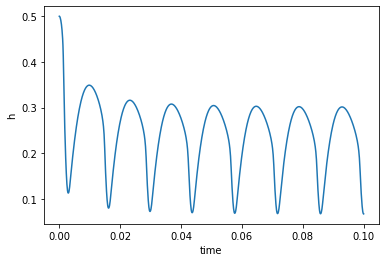

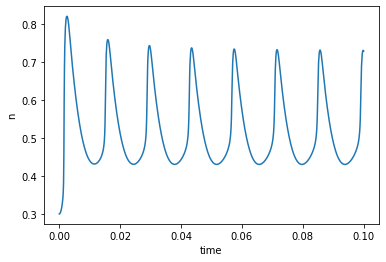

In [6]:
# Driving current in amps/cm2. A constant 2.5e-5 gives nice tonic spikes, but this can be any function of time.
def I(t):
    return 2.5e-5

# Solve and plot. Start with u=0 and m, h and n at equilibrium.
duration = 0.1 #seconds
hh_track = solve_ivp(fun = hh_flow, t_span=[0,duration], y0=[0, m_0(0), h_0(0), n_0(0)], dense_output=True, rtol = 1e-8, atol=1e-10)
N_steps = 1000
time = np.linspace(0, duration, num=N_steps)

variables = enumerate(['u', 'm', 'h', 'n'])
for i, label in variables:
    plt.plot(time, [hh_track.sol(t)[i] for t in time])
    plt.ylabel(label)
    plt.xlabel('time')
    plt.show()